In [1]:
import shutil
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import os 
import sys
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import lhs
%load_ext autoreload
%autoreload 2
import time

In [2]:
sys.path.append('../scripts/')

In [3]:
import bayesiangp

In [4]:
# Generate synthetic data
inputs = lhs(3,100)
inputs[:,0] = inputs[:,0]*2 + 5
outputs = 10*np.square(inputs[:,0]) + inputs[:,0]*inputs[:,1] + 2*inputs[:,2] + 8*np.random.randn(len(inputs))

In [5]:
np.savetxt('Xtr.txt', inputs)
np.savetxt('Ytr.txt', outputs)

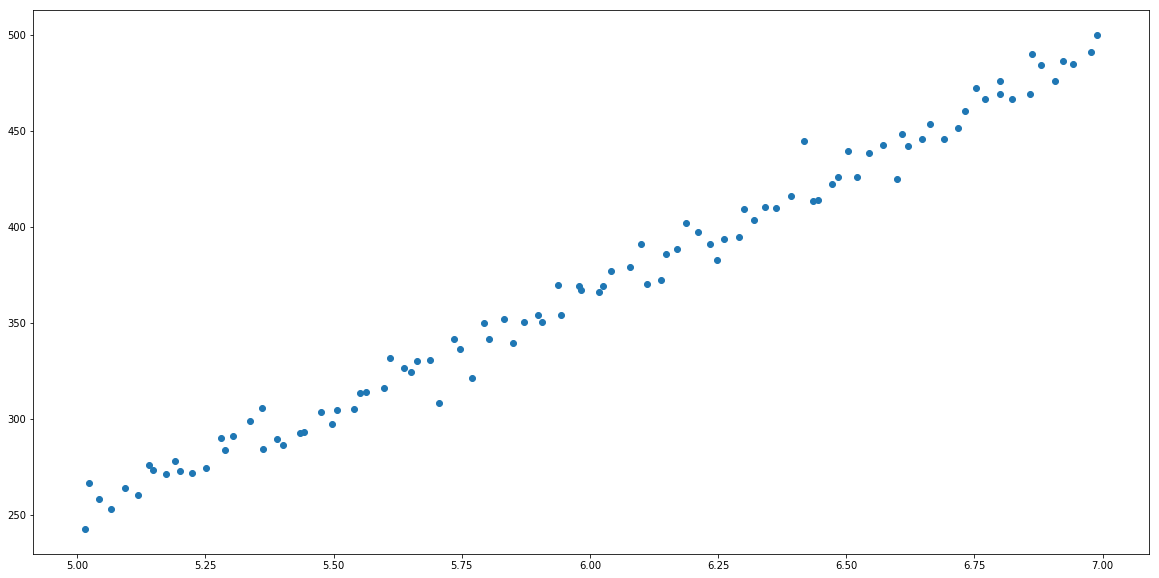

In [6]:
plt.figure(figsize =(20,10))
plt.scatter(inputs[:,0],outputs)

In [7]:
labels = ['x1','x2', 'x3']

In [8]:
# Normalizing the outputs 
mean_y = np.mean(outputs)
std_y = np.std(outputs)
outputsnorm = (outputs - mean_y)/std_y

scaling_y = [mean_y, std_y]   # storing the scaling terms


In [9]:
# normalizing the inputs
mean_x = np.mean(inputs, axis = 0)
std_x = np.std(inputs, axis = 0, keepdims = True)

inputsnorm = (inputs - mean_x)/std_x

scaling_inp = [mean_x, std_x]

In [10]:
model = bayesiangp.BayesianGP(inputsnorm, outputsnorm,'Matern32', 1e-2)

In [11]:
n_inputs = 3

In [12]:
# Initializing the hyperparameters
beta = 1.5*tf.ones(n_inputs, tf.float32)
varm = 0.8
loc = 0.0


initial_state = [beta, varm, loc]

In [13]:
mcmc_samples = 4000
burn_in = 3000
num_leapfrog_steps = 3
num_warmup_iters = burn_in
step_size, beta_next, varm_next, loc_next = model.warmup(initial_state,num_warmup_iters, num_leapfrog_steps)
print(step_size)

Warmup: 
Step  0
Step  500
Step  1000
Step  1500
Step  2000
Step  2500
Time per step in warm up:  0.007834607680638631
0.45259246


In [14]:
initial_state = [beta_next, varm_next, loc_next]

In [15]:
loc_probs_, varm_probs_, beta_probs_, acceptance_rate_ = model.mcmc(mcmc_samples, burn_in, initial_state,step_size, num_leapfrog_steps)

Acceptance rate of the HMC sampling: 0.48775


In [16]:
results_path = '../results/toy_examplev2/'

In [17]:
# Plotting and saving the chains for the inverse lengthscale 
t = np.arange(mcmc_samples)
for i in range(n_inputs):
    plt.figure(figsize = (20,10))
    plt.plot(t,beta_probs_[:,i])
    title = 'Beta_for_' +  labels[i]
    plt.title(title)
    figpath = results_path + 'mcmc_chains/' + title + '.png'
    plt.savefig(figpath)
    plt.close()

    
# Plotting and saving the chains for the variances  
plt.figure(figsize = (20,10))
plt.plot(t,varm_probs_)
title = 'variance'
plt.title(title)
figpath = results_path + 'mcmc_chains/' + title + '.png'
plt.savefig(figpath)
plt.close()



# Plotting and saving the chains for the constant mean function
plt.figure(figsize = (20,10))
plt.plot(t,loc_probs_[:])
title = 'constant_mean'
plt.title(title)
figpath = results_path + 'mcmc_chains/' + title + '.png'
plt.savefig(figpath)
plt.close()

In [18]:
hyperpar_samples = [loc_probs_, varm_probs_, beta_probs_]

In [19]:
# Generating prediction for training  data
mean_pos, var_pos, samples = model.samples(inputsnorm, hyperpar_samples, num_samples = 20, with_point_samples = True)

In [20]:
print(mean_pos.shape)
print(var_pos.shape)
print(samples.shape)

(100,)
(100,)
(80000, 100)


In [21]:
std_pos = np.sqrt(var_pos)
# Converting to the right scale
mean_posf = mean_pos*std_y + mean_y 
std_posf = std_pos*std_y 
samplesf = samples*std_y + mean_y

lower = np.percentile(samplesf,2.5, axis = 0)
upper = np.percentile(samplesf,97.5, axis = 0)
print(lower.shape)
print(upper.shape)

(100,)
(100,)


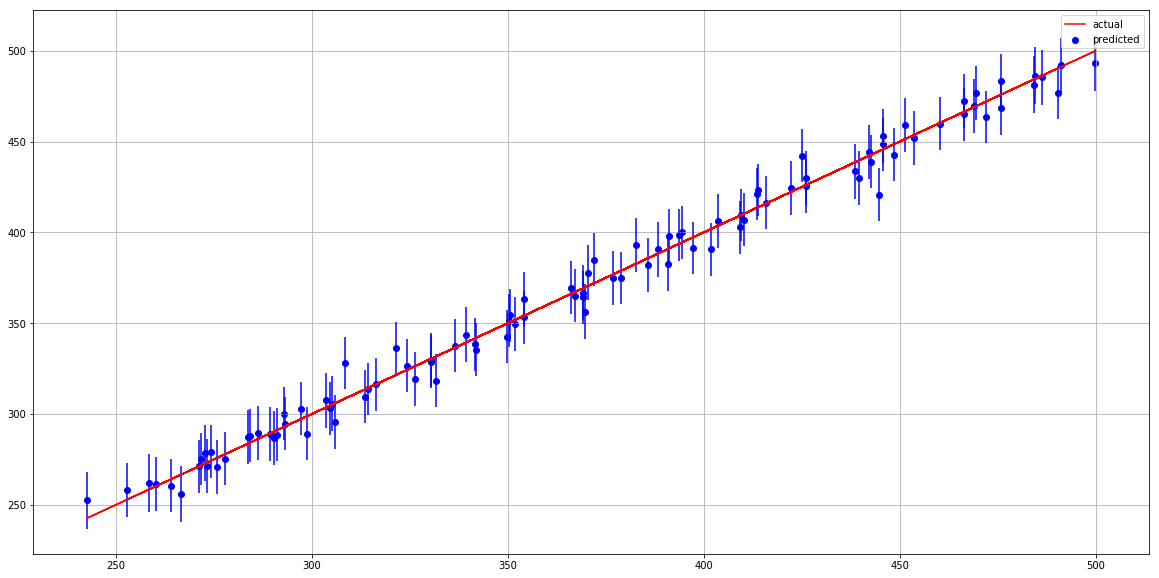

In [22]:
# Predicted vs actual
plt.figure(figsize =(20,10))
plt.plot(outputs, outputs , color = 'red', label ='actual')
plt.scatter(outputs, mean_posf, color = 'blue', label = 'predicted')
plt.vlines(outputs,lower, upper, color = 'blue')
plt.legend()
figpath = results_path + 'predicted_vs_actual.png'
plt.savefig(figpath)
plt.grid()
# plt.close()

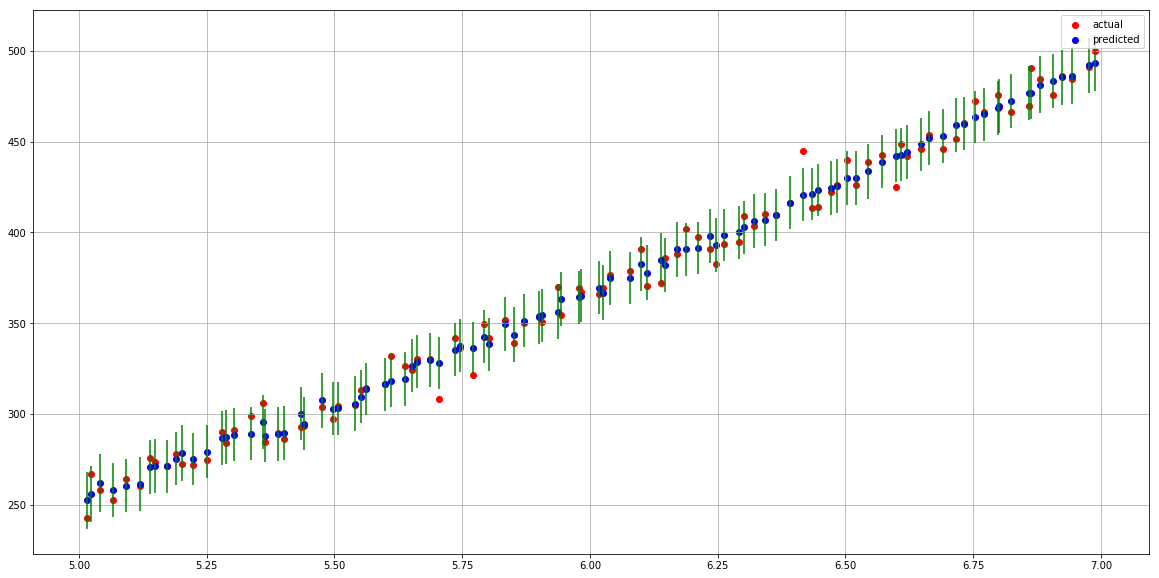

In [23]:
plt.figure(figsize =(20,10))
plt.scatter(inputs[:,0], outputs , color = 'red', label ='actual')
plt.scatter(inputs[:,0], mean_posf, color = 'blue', label = 'predicted')
plt.vlines(inputs[:,0],lower, upper, color = 'green')
plt.legend()

plt.grid()